In [1]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
path = '/content/drive/MyDrive/Colab Notebooks/TFM_en_colab'
os.chdir(path)

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

In [3]:
regressors = {
    'LR': LinearRegression(),
    'adaBoostRegressor': AdaBoostRegressor(random_state=256),
    'baggingRegressor': BaggingRegressor(random_state=256),
    'GBR': GradientBoostingRegressor(random_state=256),
    'DT': DecisionTreeRegressor(random_state=256)
}

params = {
    'LR':{
        'fit_intercept':[True, False]
    },
    'adaBoostRegressor':{
        'n_estimators':[2,4,8,16,32,64,128],
        'learning_rate':[1e-3, 1e-2, 1e-1, 1, 10, 1e2],
        'loss':['linear','square']
    },
    'baggingRegressor':{
        'n_estimators':[2,4,8,16,32,64],
        'max_samples':[5,10,25,40],
        'max_features':[1,2,3]
    },
    'GBR':{
        'loss':['squared_error','absolute_error'],
        'learning_rate':[1e-3, 1e-2, 1e-1, 1, 10, 1e2],
        'n_estimators':[2,4,8,16,32,64],
        'validation_fraction':[0.05, 0.1, 0.2], # subconjunto de validacion
        'n_iter_no_change':[2,3, 5, 10], # tras varias iteraciones loss function no mejora, fin del entrenamiento
        'tol':[1e-4, 1e-3, 1e-2, 1e-1], # una tolerancia al decrecimiento
    },
    'DT':{
        'criterion':['squared_error','absolute_error','poisson'],
        'max_depth':[None,1,2,3,4],
        'min_samples_split':[2,4,8,16,32],
        'min_samples_leaf': [1,2,3,5,10,20]
    }
}


In [4]:
scoring = {
    'r2': 'r2',
    'mape':'neg_mean_absolute_percentage_error',
    'mae': 'neg_mean_absolute_error',
    'medae':'neg_median_absolute_error',
    'rmsle': 'neg_root_mean_squared_log_error',
    'mpd':'neg_mean_poisson_deviance'
}


## Modelos Puerto de Newark:

### Datos Newark sin transformar

In [6]:
newark_data = pd.read_csv('../sources/newark_data.csv')


/home/gonzalopc/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.


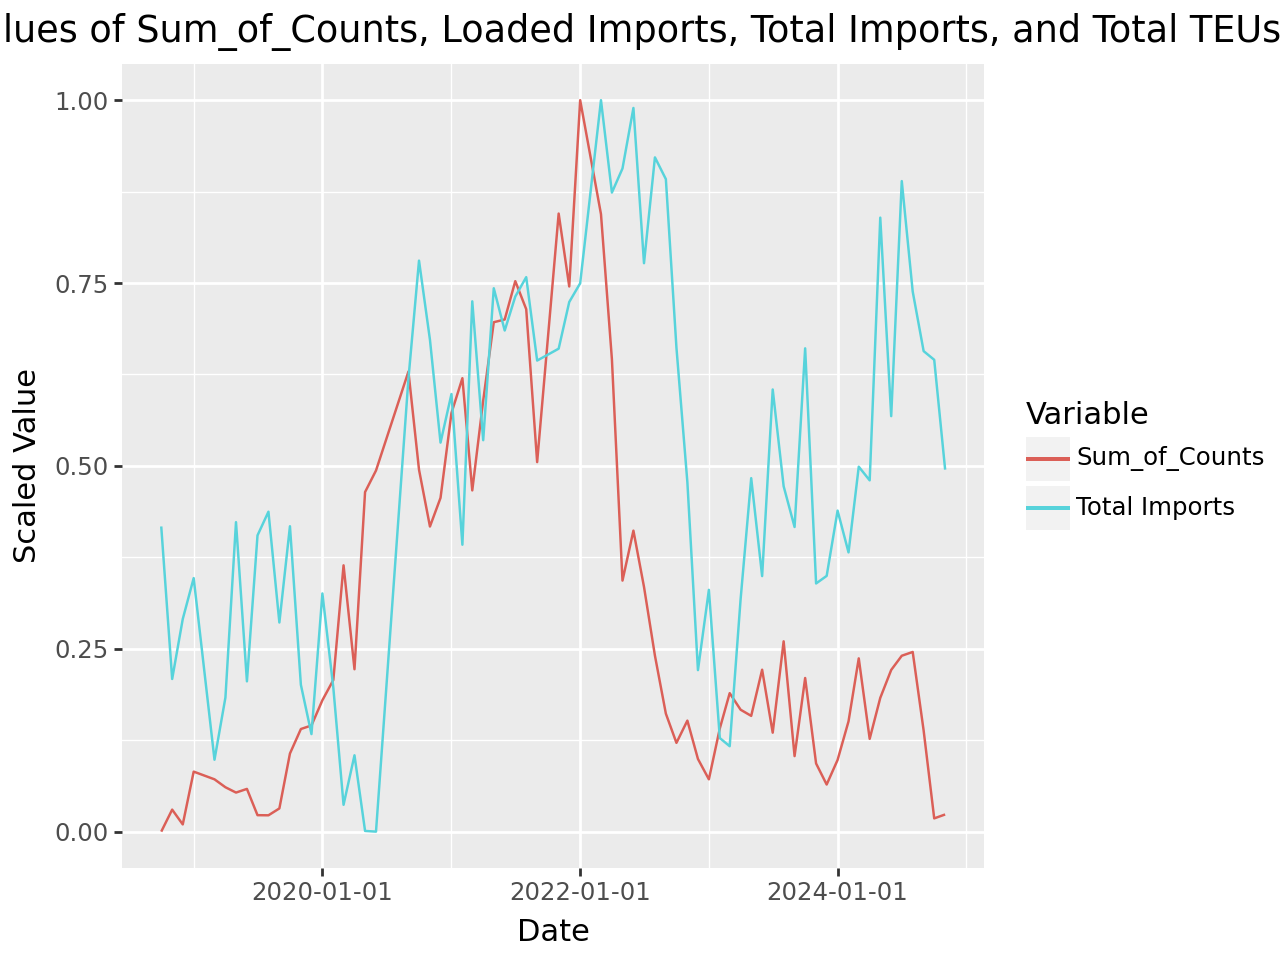

In [7]:
from plotnine import ggplot, aes, geom_line, labs
from sklearn.preprocessing import MinMaxScaler

# Select the columns to plot
columns_to_plot = ['Sum_of_Counts', 'Total Imports']

# Apply MinMaxScaler to the selected columns
scaler = MinMaxScaler()
newark_data_scaled = newark_data.copy()
newark_data_scaled[columns_to_plot] = scaler.fit_transform(newark_data[columns_to_plot])

# Melt the dataframe for plotting
newark_data_melted = newark_data_scaled.melt(id_vars=['Date'], value_vars=columns_to_plot, var_name='Variable', value_name='Value')

# Convert 'Date' to datetime
newark_data_melted['Date'] = pd.to_datetime(newark_data_melted['Date'])

# Plot using plotnine
plot = (ggplot(newark_data_melted, aes(x='Date', y='Value', color='Variable'))
    + geom_line()
    + labs(title='Scaled Values of Sum_of_Counts, Loaded Imports, Total Imports, and Total TEUs',
           x='Date', y='Scaled Value'))

plot

In [8]:
newark_data_input = newark_data.loc[:,['Date','Empty Exports','Loaded Exports','Empty Imports','Loaded Imports','Total TEUs', 'Total Imports', 'Total Exports','Ratio_Cocaine']]
newark_data_input_corr = newark_data_input[['Empty Exports','Loaded Exports','Empty Imports','Loaded Imports','Total TEUs', 'Total Imports', 'Total Exports','Ratio_Cocaine']]

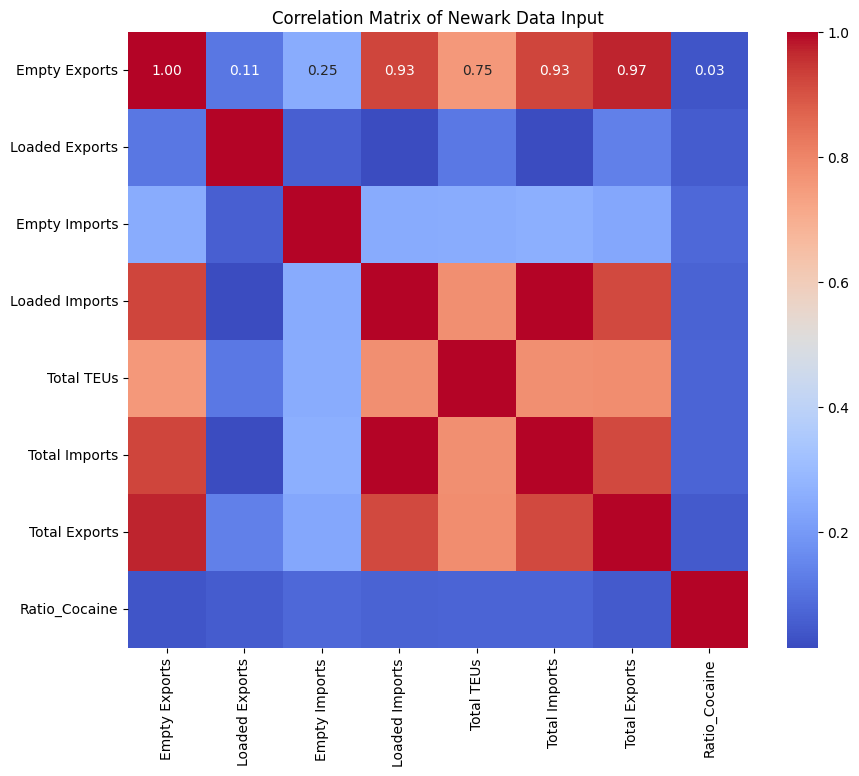

In [9]:
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = newark_data_input_corr.corr().abs()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Newark Data Input')
plt.show()

In [ ]:

X = newark_data_input.drop('Ratio_Cocaine', axis=1)
y = newark_data_input['Ratio_Cocaine']

# Opcion A: Division como train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create a RandomForestRegressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_regressor.fit(X_train, y_train)

In [ ]:
# Evaluate the model on the training data
y_train_pred = rf_regressor.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f'Training MSE: {train_mse}')
print(f'Training R2: {train_r2}')

# Predict on the test data
y_test_pred = rf_regressor.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test MSE: {test_mse}')
print(f'Test R2: {test_r2}')

In [ ]:
# Define the features and target variable
X_filtered = newark_data_input.drop(['Date', 'Ratio_Cocaine'], axis=1)
y_filtered = newark_data_input['Ratio_Cocaine']

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the RandomForestRegressor
rf_regressor_ts = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform cross-validation
for train_index, test_index in tscv.split(X_filtered):
    X_train_ts, X_test_ts = X_filtered.iloc[train_index], X_filtered.iloc[test_index]
    y_train_ts, y_test_ts = y_filtered.iloc[train_index], y_filtered.iloc[test_index]

    # Fit the model
    rf_regressor_ts.fit(X_train_ts, y_train_ts)

    # Predict on the test data
    y_test_pred_ts = rf_regressor_ts.predict(X_test_ts)

    # Evaluate the model
    test_mse_ts = mean_squared_error(y_test_ts, y_test_pred_ts)
    test_r2_ts = r2_score(y_test_ts, y_test_pred_ts)

    print(f'Test MSE: {test_mse_ts}')
    print(f'Test R2: {test_r2_ts}')

### Datos Newark Transformados

In [ ]:
# newark_data = pd.read_csv('../sources/newark_data_treated.csv')
newark_data = pd.read_csv('newark_data_treated.csv')

In [ ]:
newark_data_input = newark_data.loc[:,['Date','Empty Exports','Loaded Exports','Empty Imports','Loaded Imports','Total TEUs', 'Total Imports', 'Total Exports','Sum_of_Counts']]
newark_data_input_corr = newark_data_input[['Empty Exports','Loaded Exports','Empty Imports','Loaded Imports','Total TEUs', 'Total Imports', 'Total Exports','Sum_of_Counts']]

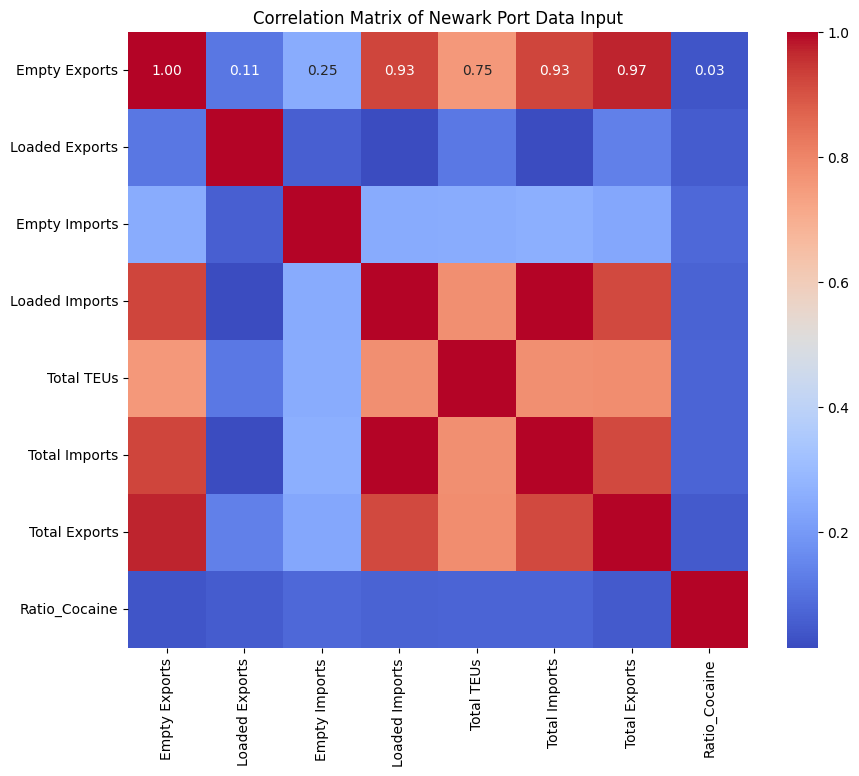

In [12]:
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = newark_data_input_corr.corr().abs()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Newark Port Data Input')
plt.show()

In [ ]:
# Use last year for test
# Convert 'Date' to datetime
newark_data_input['Date'] = pd.to_datetime(newark_data_input['Date'])

# Split the data
train_data = newark_data_input[newark_data_input['Date'] < '2024-01-01']
test_data = newark_data_input[newark_data_input['Date'] >= '2024-01-01']

In [ ]:
# Define the features and target variable for train_data
X_train = train_data.drop(['Sum_of_Counts','Date'], axis=1)
y_train = train_data['Sum_of_Counts']

# Define the features and target variable for test_data
X_test = test_data.drop(['Sum_of_Counts','Date'], axis=1)
y_test = test_data['Sum_of_Counts']

In [ ]:
regressorsCV = {}

for name in list(params.keys()):
    print("*************")
    print(name)
    print("*************")
    regressorsCV[name] = GridSearchCV(
        estimator=regressors[name],
        param_grid=params[name],
        scoring= 'neg_mean_absolute_percentage_error', #scoring,
        refit='mape',
        return_train_score=True,
        n_jobs=-1,
        cv=5, verbose = 2
    )

    regressorsCV[name].fit(X_train, y_train)

In [ ]:
test_scores = []

for name in list(params.keys()):
    print(name)
    print("Numero de configuraciones: ", pd.DataFrame.from_dict(regressorsCV[name].cv_results_).shape[0])

    # Get sorted results, ensuring lower MAPE is better
    aux = pd.DataFrame.from_dict(regressorsCV[name].cv_results_).sort_values(by="mean_test_score", ascending=True).iloc[0]

    # Ensure MAPE is positive
    mape_cv_test = abs(aux['mean_test_score'])
    mape_cv_train = abs(aux['mean_train_score'])

    # Get best model and compute MAPE
    best_model = regressorsCV[name].best_estimator_
    mape_train = mean_absolute_percentage_error(y_train, best_model.predict(X_train))
    mape_test = mean_absolute_percentage_error(y_test, best_model.predict(X_test))

    test_scores.append((name, mape_train, mape_cv_train, mape_cv_test, mape_test))


In [ ]:
resultado = pd.DataFrame(test_scores,columns=['Regressor','mape_train','mape_cv_train','mape_validation','mape_test'])
resultado

Versión alternativa tras eliminar columnas redundantes:

In [ ]:
newark_data_input_2 = newark_data.loc[:,['Date','Empty Exports','Loaded Exports','Empty Imports','Loaded Imports','Total TEUs','Sum_of_Counts']]

In [ ]:
# Use last year for test
# Convert 'Date' to datetime
newark_data_input_2['Date'] = pd.to_datetime(newark_data_input_2['Date'])

# Split the data
train_data_2 = newark_data_input_2[newark_data_input_2['Date'] < '2024-01-01']
test_data_2 = newark_data_input_2[newark_data_input_2['Date'] >= '2024-01-01']

In [ ]:
# Define the features and target variable for train_data
X_train_2 = train_data_2.drop(['Sum_of_Counts','Date'], axis=1)
y_train_2 = train_data_2['Sum_of_Counts']

# Define the features and target variable for test_data
X_test_2 = test_data_2.drop(['Sum_of_Counts','Date'], axis=1)
y_test_2 = test_data_2['Sum_of_Counts']

In [ ]:
regressorsCV_2 = {}

for name in list(params.keys()):
    print("*************")
    print(name)
    print("*************")
    regressorsCV_2[name] = GridSearchCV(
        estimator=regressors[name],
        param_grid=params[name],
        scoring= 'r2', #scoring,
        refit='r2',
        return_train_score=True,
        n_jobs=-1,
        cv=5, verbose = 2
    )

    regressorsCV_2[name].fit(X_train_2, y_train_2)

In [ ]:
test_scores_2b = []

for name in list(params.keys()):
    print(name)
    print("Numero de configuraciones: ", pd.DataFrame.from_dict(regressorsCV_2[name].cv_results_).shape[0])

    # Get sorted results, ensuring lower MAPE is better
    aux = pd.DataFrame.from_dict(regressorsCV_2[name].cv_results_).sort_values(by="mean_test_score", ascending=True).iloc[0]

    # Ensure MAPE is positive
    r2_cv_test = aux['mean_test_score']
    r2_cv_train = aux['mean_train_score']

    # Get best model and compute MAPE
    best_model = regressorsCV_2[name].best_estimator_
    r2_train = r2_score(y_train_2, best_model.predict(X_train_2))
    r2_test = r2_score(y_test_2, best_model.predict(X_test_2))

    test_scores_2b.append((name, r2_train, r2_cv_train, r2_cv_test, r2_test))


In [ ]:
resultado_2 = pd.DataFrame(test_scores_2,columns=['Regressor','mape_train','mape_cv_train','mape_validation','mape_test'])
resultado_2

In [ ]:
resultado_b = pd.DataFrame(test_scores_2b,columns=['Regressor','r2_train','r2_cv_train','r2_validation','r2_test'])
resultado_b

Eliminando más columnas redundantes

In [ ]:
newark_data_input_3 = newark_data.loc[:,['Date','Empty Exports','Total Imports','Sum_of_Counts']]

newark_data_input_3['Date'] = pd.to_datetime(newark_data_input_3['Date'])

# Split the data
train_data_3 = newark_data_input_3[newark_data_input_3['Date'] < '2024-01-01']
test_data_3 = newark_data_input_3[newark_data_input_3['Date'] >= '2024-01-01']

# Define the features and target variable for train_data
X_train_3 = train_data_3.drop(['Sum_of_Counts','Date'], axis=1)
y_train_3 = train_data_3['Sum_of_Counts']

# Define the features and target variable for test_data
X_test_3 = test_data_3.drop(['Sum_of_Counts','Date'], axis=1)
y_test_3 = test_data_3['Sum_of_Counts']

In [ ]:
regressorsCV_3 = {}

for name in list(params.keys()):
    print("*************")
    print(name)
    print("*************")
    regressorsCV_3[name] = GridSearchCV(
        estimator=regressors[name],
        param_grid=params[name],
        scoring= 'neg_mean_absolute_percentage_error', #scoring,
        refit='mape',
        return_train_score=True,
        n_jobs=-1,
        cv=5, verbose = 2
    )

    regressorsCV_3[name].fit(X_train_3, y_train_3)

In [ ]:
test_scores_3 = []

for name in list(params.keys()):
    print(name)
    print("Numero de configuraciones: ", pd.DataFrame.from_dict(regressorsCV_3[name].cv_results_).shape[0])

    # Get sorted results, ensuring lower MAPE is better
    aux = pd.DataFrame.from_dict(regressorsCV_3[name].cv_results_).sort_values(by="mean_test_score", ascending=True).iloc[0]

    # Ensure MAPE is positive
    mape_cv_test = aux['mean_test_score']
    mape_cv_train = aux['mean_train_score']

    # Get best model and compute MAPE
    best_model = regressorsCV_3[name].best_estimator_
    mape_train = mean_absolute_percentage_error(y_train_3, best_model.predict(X_train_3))
    mape_test = mean_absolute_percentage_error(y_test_3, best_model.predict(X_test_3))

    test_scores_3.append((name, mape_train, mape_cv_train, mape_cv_test, mape_test))


In [ ]:
resultado_3b = pd.DataFrame(test_scores_3b,columns=['Regressor','r2_train','r2_cv_train','r2_validation','r2_test'])
resultado_3b

In [ ]:
resultado_3 = pd.DataFrame(test_scores_3,columns=['Regressor','mape_train','mape_cv_train','mape_validation','mape_test'])
resultado_3

## Modelos Puerto de Everglades:

In [13]:
everglades_data = pd.read_csv('../sources/everglades_data.csv')

In [14]:
everglades_data_input = everglades_data.loc[:,['Date','Empty Exports','Loaded Exports','Empty Imports','Loaded Imports','Total TEUs', 'Total Imports', 'Total Exports','Sum_of_Counts']]
everglades_data_input_corr = everglades_data_input[['Empty Exports','Loaded Exports','Empty Imports','Loaded Imports','Total TEUs', 'Total Imports', 'Total Exports','Sum_of_Counts']]

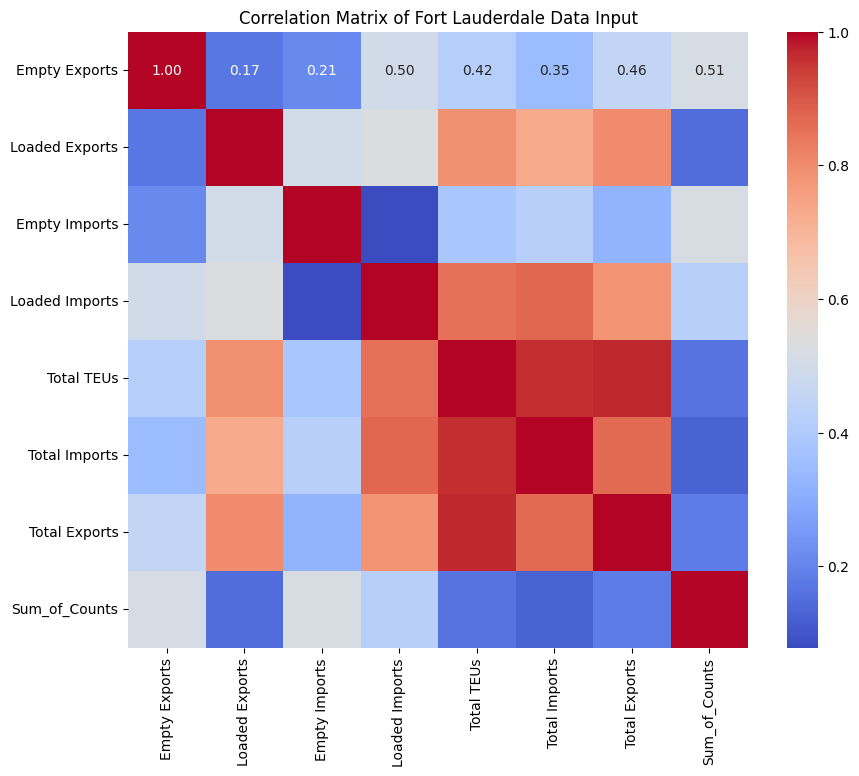

In [15]:
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = everglades_data_input_corr.corr().abs()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Fort Lauderdale Data Input')
plt.show()

In [ ]:
# Use last year for test
# Convert 'Date' to datetime
everglades_data_input['Date'] = pd.to_datetime(everglades_data_input['Date'])

# Split the data
train_data = everglades_data_input[everglades_data_input['Date'] < '2024-01-01']
test_data = everglades_data_input[everglades_data_input['Date'] >= '2024-01-01']

In [ ]:
# Define the features and target variable for train_data
X_train = train_data.drop('Sum_of_Counts', axis=1)
y_train = train_data['Sum_of_Counts']

# Define the features and target variable for test_data
X_test = test_data.drop('Sum_of_Counts', axis=1)
y_test = test_data['Sum_of_Counts']

In [ ]:
regressors = {
    'LR', LinearRegression(),
    'adaBoostRegressor', AdaBoostRegressor(random_state=256),
    'baggingRegressor', BaggingRegressor(random_state=256),
    'GBR', GradientBoostingRegressor(random_state=256)
}

params = {
    'LR':{
        'fit_intercept':[True, False]
    },
    'adaBoostRegressor':{
        'n_estimators':[2,4,8,16,32,64],
        'learning_rate':[1e-3, 1e-2, 1e-1, 1, 10, 1e2],
        'loss':['linear','square']
    },
    'baggingRegressor':{
        'n_estimators':[2,4,8,16,32,64],
        'max_samples':[5,10,25,40],
        'max_features':[1,2,3]
    },
    'GBR':{
        'loss':['linear','square'],
        'learning_rate':[1e-3, 1e-2, 1e-1, 1, 10, 1e2],
        'n_estimators':[2,4,8,16,32,64],
        'validation_fraction':[0.05, 0.1, 0.2], # subconjunto de validacion
        'n_iter_no_change':[2,3, 5, 10], # tras varias iteraciones loss function no mejora, fin del entrenamiento
        'tol':[1e-4, 1e-3, 1e-2, 1e-1], # una tolerancia al decrecimiento
    }
}


In [ ]:
regressorsCV = {}

for name in list(params.keys()):
    print("*************")
    print(name)
    print("*************")
    regressorsCV[name] = GridSearchCV(
        estimator=regressors[name],
        param_grid=params[name],
        scoring=['mean_squared_error','r2_score'],
        return_train_score=True,
        n_jobs=-1,
        cv=5, verbose = 2
    )

    regressorsCV[name].fit(X_train, y_train)

In [ ]:
# compute results
test_scores = []


for name in list(params.keys()):
    print(name)
    print("Número de configuraciones: ", pd.DataFrame.from_dict(regressorsCV[name].cv_results_).shape[0])
    aux = pd.DataFrame.from_dict(regressorsCV[name].cv_results_).sort_values(by="mean_test_score",ascending=False).iloc[0]

    # Accuracy
    mse_cv_test = aux['mean_test_score']
    mse_cv_train = aux['mean_train_score']

    mse_train = mean_squared_error(y_train, regressorsCV[name].predict(X_train))
    mse_test = mean_squared_error(y_test, regressorsCV[name].predict(X_test))

    # R2:
    r2_train = r2_score(y_train, regressorsCV[name].predict(X_train))
    r2_test = r2_score(y_test, regressorsCV[name].predict(X_test))

    test_scores.append((name,mse_train,mse_cv_train,mse_cv_test,mse_test,r2_train,r2_test))

# mirar el rendimiento en validacion para obtener el mejor modelo
resultado = pd.DataFrame(test_scores,columns=['Regressor','mse_train','mse_CV_train','mse_validation','mse_test','r2_train','r2_test'])
sorted_resultado = resultado.sort_values(by="mse_validation",ascending=False)

In [ ]:
sorted_resultado

## Modelo de series temporales

In [3]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

/home/gonzalopc/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [126]:
# everglades_data = pd.read_csv('everglades_data.csv')
everglades_data = pd.read_csv('../sources/everglades_data.csv')

Serie temporal para Loaded Imports en Miami/Fort Lauderdale:

In [127]:
# Añadir 'Loaded Imports' como variable exógena para predecir "Count of Event_Other Drugs**"
df_imports = everglades_data[['Date', 'Count of Event_Other Drugs**','Loaded Imports']]

In [128]:
df_imports['Date'] = pd.to_datetime(df_imports['Date'])

/tmp/ipykernel_882889/1810795910.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imports['Date'] = pd.to_datetime(df_imports['Date'])


In [129]:
df_imports.rename(columns={
    'Date': 'ds', 
    'Count of Event_Other Drugs**': 'y',  # This should be your target variable
    'Loaded Imports': 'loaded_imports'
}, inplace=True)

/tmp/ipykernel_882889/299947515.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imports.rename(columns={


No tengo datos del regresor exogeno para febrero de 2025 en adelante.

In [130]:
train = df_imports[df_imports['ds'] < '2024-06-30']
validation = df_imports[(df_imports['ds'] >= '2024-06-30') & (df_imports['ds'] < '2024-09-30')]
# validation = df_imports[df_imports['ds'] >= '2024-06-30']
test = df_imports[df_imports['ds'] >= '2024-09-30']

In [131]:
# df_imports_train['cap'] = 0.5
m = Prophet()
m.add_regressor('loaded_imports')
m.fit(train)

20:28:01 - cmdstanpy - INFO - Chain [1] start processing


20:28:01 - cmdstanpy - INFO - Chain [1] done processing


Probar con regresor exógeno (para ultimo trimestre de 2024 y para enero de 2025 con datos de NY)

Opción B con scores

In [132]:
# Crear conjunto de validación para predicciones
future_validation = validation[['ds', 'loaded_imports']]

# Hacer predicciones sobre el conjunto de validación
forecast_validation = m.predict(future_validation)

In [133]:
# Evaluación del modelo
y_true = validation['y'].values
y_pred = forecast_validation['yhat'].values

# Calcular MAPE y R²
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAPE: {mape:.4f}")
print(f"R² Score: {r2:.4f}")

MAPE: 4.4790
R² Score: -99.6696


In [106]:
# Definir horizonte de predicción (primeros 6 meses de 2025)
future = df_imports[(df_imports['ds'] > '2024-09-30') & (df_imports['ds'] <= '2024-12-31')][['ds', 'loaded_imports']]

forecast = m.predict(future)

In [137]:
validation

,ds,y,loaded_imports
69,2024-07-01,0.566155,-0.833225
70,2024-08-01,0.362103,-0.832306
71,2024-09-01,0.219513,-0.811215


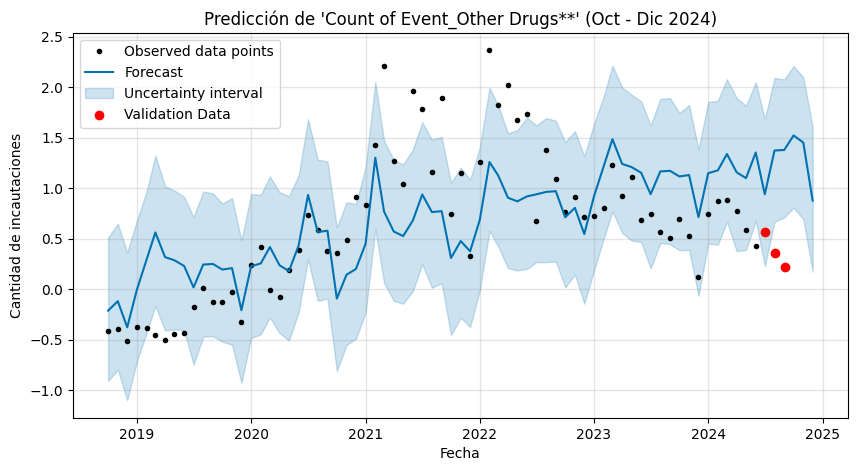

In [ ]:

# Graficar resultados
fig, ax = plt.subplots(figsize=(10, 5))
model.plot(forecast, ax=ax)
ax.scatter(validation['ds'], validation['y'], color='green', label='Validation Data')
ax.scatter(test['ds'], test['y'], color='red', label='Prediction Data')
plt.title("Predicción de 'Count of Event_Other Drugs**' (Oct - Dic 2024)")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de incautaciones")
plt.legend()
plt.show()

Sin regresor exógeno para 6 meses de 2025:

In [113]:
df_imports = everglades_data[['Date', 'Count of Event_Other Drugs**']]
df_imports['Date'] = pd.to_datetime(df_imports['Date'])

df_imports.rename(columns={
    'Date': 'ds', 
    'Count of Event_Other Drugs**': 'y'
}, inplace=True)

/tmp/ipykernel_882889/1869482108.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imports['Date'] = pd.to_datetime(df_imports['Date'])
/tmp/ipykernel_882889/1869482108.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imports.rename(columns={


In [114]:
train = df_imports[df_imports['ds'] < '2024-06-30']
validation = df_imports[df_imports['ds'] >= '2024-06-30']

In [115]:
m = Prophet()
m.fit(train)

20:21:31 - cmdstanpy - INFO - Chain [1] start processing


20:21:31 - cmdstanpy - INFO - Chain [1] done processing


In [118]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-10-01,-0.117122,-0.929489,0.532209,-0.117122,-0.117122,-0.095370,-0.095370,-0.095370,-0.095370,-0.095370,-0.095370,0.0,0.0,0.0,-0.212492
1,2018-11-01,-0.097451,-0.790726,0.613189,-0.097451,-0.097451,-0.021300,-0.021300,-0.021300,-0.021300,-0.021300,-0.021300,0.0,0.0,0.0,-0.118752
2,2018-12-01,-0.078415,-1.088481,0.325140,-0.078415,-0.078415,-0.299474,-0.299474,-0.299474,-0.299474,-0.299474,-0.299474,0.0,0.0,0.0,-0.377890
3,2019-01-01,-0.058745,-0.742377,0.696147,-0.058745,-0.058745,0.054798,0.054798,0.054798,0.054798,0.054798,0.054798,0.0,0.0,0.0,-0.003947
4,2019-02-01,-0.039074,-0.420044,1.007788,-0.039074,-0.039074,0.332866,0.332866,0.332866,0.332866,0.332866,0.332866,0.0,0.0,0.0,0.293792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2024-07-31,1.227927,0.636347,2.006790,1.227920,1.227936,0.145669,0.145669,0.145669,0.145669,0.145669,0.145669,0.0,0.0,0.0,1.373596
71,2024-08-31,1.247413,0.620999,2.073588,1.247397,1.247432,0.131253,0.131253,0.131253,0.131253,0.131253,0.131253,0.0,0.0,0.0,1.378666
72,2024-09-30,1.266271,0.816884,2.205303,1.266244,1.266302,0.256543,0.256543,0.256543,0.256543,0.256543,0.256543,0.0,0.0,0.0,1.522814
73,2024-10-31,1.285757,0.746181,2.153855,1.285718,1.285802,0.166430,0.166430,0.166430,0.166430,0.166430,0.166430,0.0,0.0,0.0,1.452187


/home/gonzalopc/.local/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


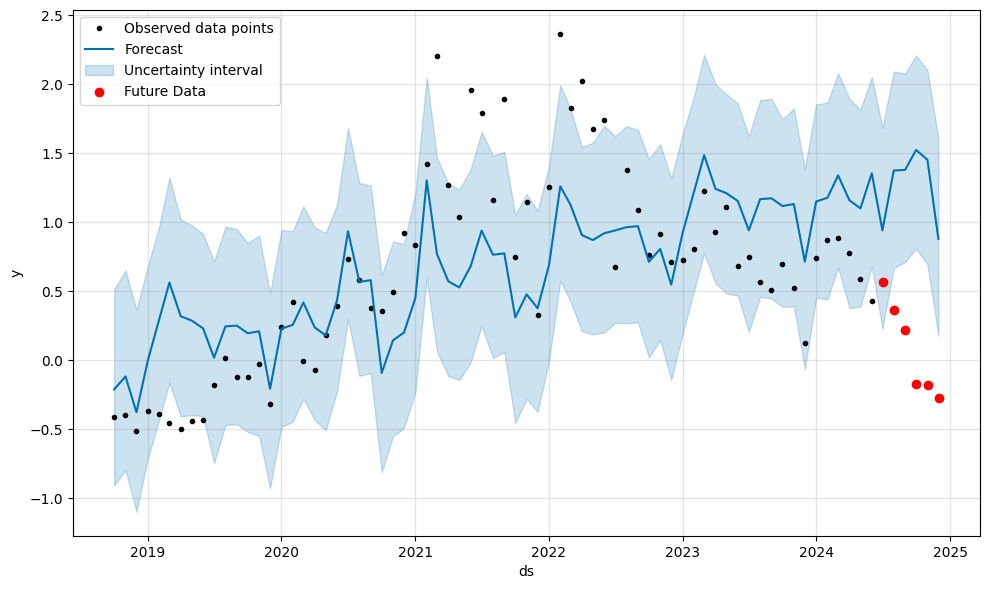

In [120]:
future = m.make_future_dataframe(periods=6, freq='M')
future = future.merge(df_imports, on='ds', how='left')

# Hacer predicciones
forecast = m.predict(future)

# Graficar resultados
fig = m.plot(forecast)
plt.scatter(validation['ds'], validation['y'], color='red', label='Future Data')
plt.legend()
plt.show()

In [125]:
# Evaluación del modelo
y_true = validation.loc[validation['ds'].isin(forecast_validation['ds']), 'y'].values
y_pred = forecast_validation['yhat'].values

# Calcular MAPE y R²
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAPE: {mape:.4f}")
print(f"R² Score: {r2:.4f}")

MAPE: 4.4790
R² Score: -99.6696
